<a href="https://colab.research.google.com/github/maiaufrrj/BRtrading/blob/main/forecast_prophet01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install plotly fbprophet pickle5

  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219321 sha256=a3e3095b2501b440b34bf2a25163051eb7b5a7e96616e44de7498a7fe2f06e25
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.io as pio
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
import math
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



####Setor: Saúde
* NotreDame Intermédica (GNDI3);
* Raia Drogasil (RADL3);
* Hapvida (HAPV3);
* Hypera (HYPE3);
* SulAmérica (SULA11);
* Fleury (FLRY3);
* Qualicorp (QUAL3).

In [186]:
acao = 'ITSA4.SA'
import pickle5 as pickle
with open('df_teste.pkl', 'rb') as f:
    data = pickle.load(f)

#df_teste = pd.read_pickle("df_teste.pkl")
df_teste = data
df = df_teste.dropna(axis='columns', thresh=200)

#FORECASTING com ações

#Teste de Dickey Fuller Aumentado - Verificando Estacionariedade
from statsmodels.tsa.stattools import adfuller
X = df[acao].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print('Último valor real:' + str(df[acao][-1]))
#RESULTADO: SÉRIE NÃO-ESTACIONÁRIA

#Dividindo dataset
ativo=pd.DataFrame(df[acao]).reset_index()
train_size = int(0.90 * len(ativo))
test_size = len(ativo) - train_size

univariate_df = ativo[['Date', acao]].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

#instanciando e treinando modelo
model = Prophet(changepoint_prior_scale= 0.01, seasonality_prior_scale= 1.0, daily_seasonality=True, weekly_seasonality=True) #hiperparâmetros ajustados
model.fit(train)
future = model.make_future_dataframe(periods=360, freq='d')

# Conjunto de Previsão
y_pred = model.predict(future)
print('valor previsto:' + str(y_pred.yhat.values[-1]))
print('mínimo valor previsto:' + str(y_pred.yhat_lower.values[-1]))
print('máximo valor previsto:' + str(y_pred.yhat_upper.values[-1]))

from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, y_pred)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


ADF Statistic: -2.517598
p-value: 0.111251
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Último valor real:11.319999694824219
valor previsto:12.797301095165237
mínimo valor previsto:11.973529731264135
máximo valor previsto:13.574469640538615


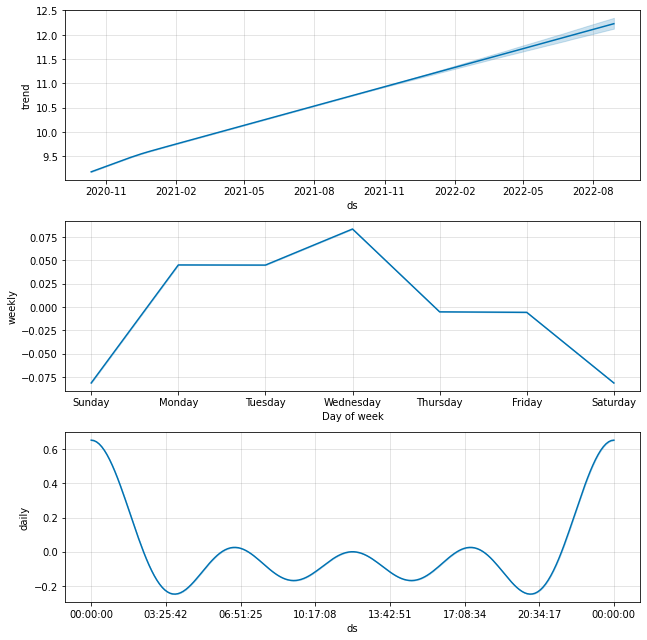

In [187]:
componentes = model.plot_components(y_pred)

In [188]:
#validação cruzada
#https://facebook.github.io/prophet/docs/diagnostics.html
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial='200 days', period='45 days', horizon = '15 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-05-20 00:00:00 and 2021-08-18 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [189]:
relatorio_cv = performance_metrics(df_cv)
relatorio_cv.sort_values(by='mape').head(50)

,horizon,mse,rmse,mae,mape,mdape,coverage
2,3 days,0.006858,0.082812,0.081487,0.007328,0.007405,1.000000
1,2 days,0.039191,0.197966,0.124188,0.011384,0.007405,1.000000
9,10 days,0.031908,0.178629,0.172619,0.015261,0.017814,1.000000
8,9 days,0.075813,0.275342,0.218003,0.019571,0.018497,1.000000
0,1 days,0.106790,0.326787,0.227055,0.021024,0.009435,1.000000
3,4 days,0.088914,0.298185,0.230574,0.021237,0.008855,1.000000
4,5 days,0.119631,0.345877,0.288294,0.026728,0.008808,1.000000
10,11 days,0.123511,0.351442,0.306088,0.027896,0.017814,1.000000
6,7 days,0.126915,0.356252,0.307346,0.028313,0.012696,1.000000
5,6 days,0.148950,0.385940,0.328949,0.030243,0.043950,1.000000


In [190]:
relatorio_cv['mape'].mean()

0.02889316232840635

In [23]:
#tunando hiperparâmetros do modelo
import itertools
cutoffs = pd.to_datetime(['2021-02-01', '2021-05-01', '2021-08-01'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Gerando combinação de parâmetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # guardar MAPEs para cada parâmetro aqui

# Usar validação cruzada para avaliar todos os parâmetros
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Encontrar melhores parâmetros
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc9d5904090>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc9d5904f10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc9d4980d50>
INFO:fbprophet:Disabling yearly seaso

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.086555
1                     0.001                     0.10  0.090632
2                     0.001                     1.00  0.091541
3                     0.001                    10.00  0.091518
4                     0.010                     0.01  0.078006
5                     0.010                     0.10  0.076759
6                     0.010                     1.00  0.076391
7                     0.010                    10.00  0.077700
8                     0.100                     0.01  0.078201
9                     0.100                     0.10  0.079609
10                    0.100                     1.00  0.077812
11                    0.100                    10.00  0.079388
12                    0.500                     0.01  0.096356
13                    0.500                     0.10  0.096327
14                    0.500                     1.00  0

In [24]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mape
0,0.001,0.01,0.086555
1,0.001,0.10,0.090632
2,0.001,1.00,0.091541
3,0.001,10.00,0.091518
4,0.010,0.01,0.078006
5,0.010,0.10,0.076759
6,0.010,1.00,0.076391
7,0.010,10.00,0.077700
8,0.100,0.01,0.078201
9,0.100,0.10,0.079609


In [32]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [55]:
data_pred = y_pred.ds
pred = y_pred.yhat
close = df['VALE3.SA']
#vazio=pd.Series(['-','-','-','-'])
#vazio=pd.Series([0,0])

#close = close.append(vazio)
df2= df
df2 = df2.reset_index()

In [60]:
data_real = df2.Date
#data_real = data_real.append(vazio)
df_final = pd.DataFrame(close.values, index=data_real, columns=['VALE3.SA real'])
df_final['Previsão'] = pred.values
df_final

array([ 52.78379787,  53.29743347,  53.26462896,  53.58519984,
        54.41591207,  54.55262156,  55.06625716,  55.03345265,
        55.35402354,  56.18473576,  56.32144525,  56.83508086,
        56.80227635,  57.12284723,  58.09026895,  58.60390455,
        58.57110004,  58.89167092,  59.72238315,  59.85909264,
        60.37272824,  60.33992373,  60.66049462,  61.49120684,
        61.62791633,  62.14155193,  62.10874742,  63.26003054,
        63.39674003,  63.91037563,  63.87757113,  64.19814201,
        65.02885424,  65.16556373,  65.67919933,  65.64639481,
        65.96696569,  66.79767788,  66.93438736,  67.44802296,
        67.41516912,  67.73569067,  68.56625489,  68.70291505,
        69.21650132,  69.18364747,  69.50416902,  70.33188149,
        70.46759106,  70.98022674,  72.09370573,  72.2294153 ,
        72.74205099,  73.78298642,  73.90418727,  74.40231424,
        74.3540011 ,  74.65906335,  75.44324967,  75.56445053,
        76.03471802,  75.9585454 ,  76.23574817,  76.93

In [ ]:
grafico_final = px.line(df_final, y=['Venda Mensal Real', 'Previsão Mensal'], x=df_final.index)
grafico_final.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape=mean_absolute_percentage_error(venda_mensal_bruta, pred[:48])
mape = "%0.2f" % mape
print('Ao longo da série temos uma MAPE de: ' + mape + '%')